In [25]:
# Importamos
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [26]:
# Descargar stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Carga dataset IMDb
top_words = 10000  # Limitar vocabulario a 10,000 palabras
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
word_index = imdb.get_word_index()
index_to_word = {index + 3: word for word, index in word_index.items()}
index_to_word[0] = '<PAD>'
index_to_word[1] = '<START>'
index_to_word[2] = '<UNK>'

In [28]:
# Función para decodificar reseñas
def decode_review(sequence):
    return " ".join([index_to_word.get(i, '?') for i in sequence])

In [29]:
# Preprocesamiento de texto
maxlen = 200  # Longitud máxima de secuencias
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

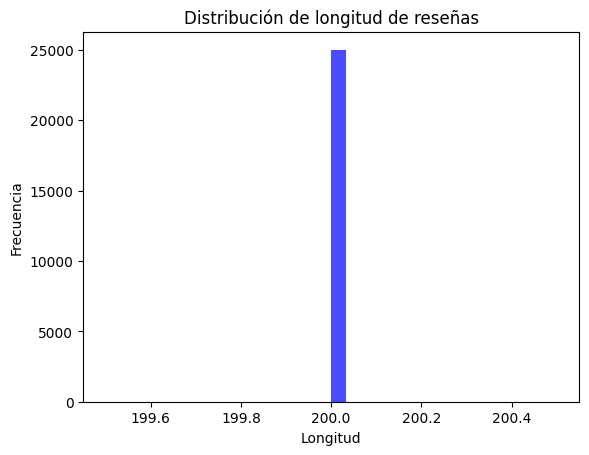

In [30]:
# Análisis exploratorio
review_lengths = [len(x) for x in X_train]
plt.hist(review_lengths, bins=30, color='blue', alpha=0.7)
plt.title('Distribución de longitud de reseñas')
plt.xlabel('Longitud')
plt.ylabel('Frecuencia')
plt.show()

In [31]:
# Obtener palabras más frecuentes en reseñas positivas y negativas
def get_top_words(sequences, labels, sentiment, num_words=20):
    words = [index_to_word.get(idx, '') for seq in sequences[labels == sentiment] for idx in seq]
    word_counts = Counter(words)
    return dict(word_counts.most_common(num_words))

positive_words = get_top_words(X_train, y_train, 1)
negative_words = get_top_words(X_train, y_train, 0)

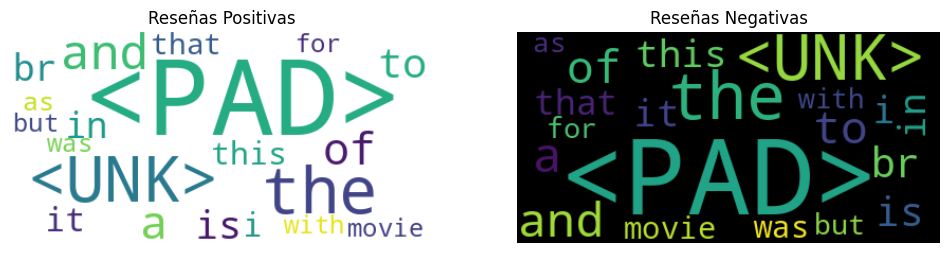

In [32]:
# Nubes de palabras
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
WordCloud(background_color='white').generate_from_frequencies(positive_words).to_image()
axes[0].imshow(WordCloud(background_color='white').generate_from_frequencies(positive_words), interpolation='bilinear')
axes[0].set_title('Reseñas Positivas')
axes[0].axis('off')
axes[1].imshow(WordCloud(background_color='black').generate_from_frequencies(negative_words), interpolation='bilinear')
axes[1].set_title('Reseñas Negativas')
axes[1].axis('off')
plt.show()

In [33]:
# Construcción del modelo con LSTM
embedding_dim = 128
lstm_units = 64

model = Sequential([
    Embedding(input_dim=top_words, output_dim=embedding_dim, input_length=maxlen),
    LSTM(lstm_units, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - accuracy: 0.7044 - loss: 0.5504 - val_accuracy: 0.8748 - val_loss: 0.3138
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 268ms/step - accuracy: 0.8999 - loss: 0.2601 - val_accuracy: 0.8642 - val_loss: 0.3313
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 253ms/step - accuracy: 0.9374 - loss: 0.1799 - val_accuracy: 0.8798 - val_loss: 0.3245
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 253ms/step - accuracy: 0.9540 - loss: 0.1350 - val_accuracy: 0.8634 - val_loss: 0.3522
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 253ms/step - accuracy: 0.9598 - loss: 0.1150 - val_accuracy: 0.8724 - val_loss: 0.4074


In [35]:
# Evaluación del modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Precisión en prueba: {accuracy:.2f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.8578 - loss: 0.4492
Precisión en prueba: 0.86


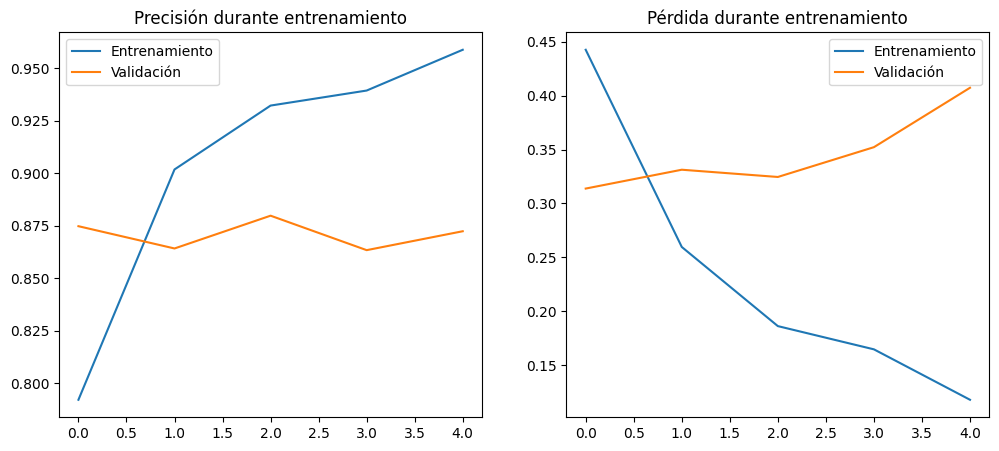

In [36]:
# Grafica desempeño
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(history.history['accuracy'], label='Entrenamiento')
axes[0].plot(history.history['val_accuracy'], label='Validación')
axes[0].set_title('Precisión durante entrenamiento')
axes[0].legend()
axes[1].plot(history.history['loss'], label='Entrenamiento')
axes[1].plot(history.history['val_loss'], label='Validación')
axes[1].set_title('Pérdida durante entrenamiento')
axes[1].legend()
plt.show()